In [10]:
# import module

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
from astrodendro import analysis
import pandas as pd
from scipy.optimize import curve_fit

In [11]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)
def fit_gaussian(x, y):
    initial_height = max(y)
    initial_center = x[np.argmax(y)]
    initial_width = 1
    initial_params = [initial_height, initial_center, initial_width]
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_params)
    return popt
def calculate_fwhm(stddev):
    return 2 * np.sqrt(2 * np.log(2)) * stddev
def analyze_spectra(coordinates_list, data):
    spectra_list = []
    for i, j in coordinates_list:
        spectra_list.append(data[:, i, j])
    spe = np.sum(spectra_list, axis=0)
    x_spe = np.arange(len(spe))
    params = fit_gaussian(x_spe, spe)
    fwhm = calculate_fwhm(params[2])
    return params, fwhm

<>:12: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_17868\591056322.py:12: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('intensity [$M_\odot$ km s$^{-1}$]')


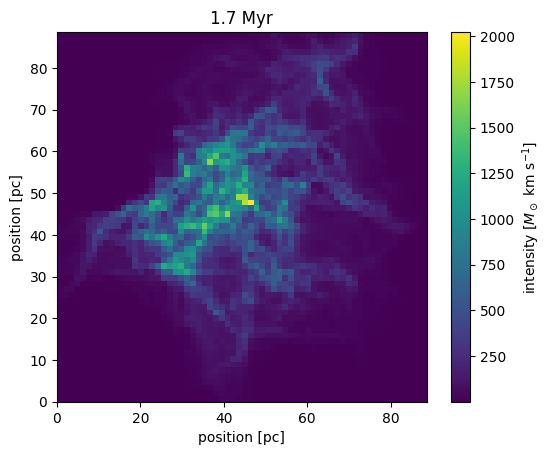

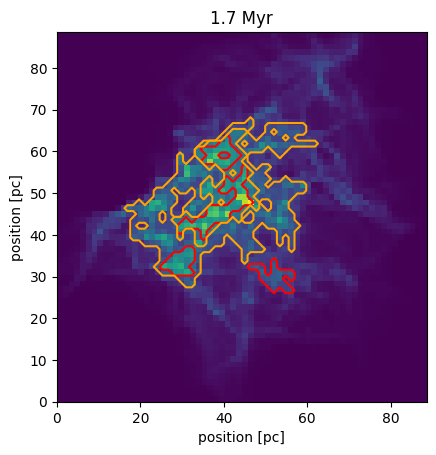

,size,radius,mass,virial_parameter
0,42.0,3.663191,17681.274058,4.148392
1,38.0,3.492715,31640.512221,7.343801
2,84.0,5.180534,83040.930547,1.802151
3,40.0,3.578968,35963.249325,2.536856


,size,radius,mass,virial_parameter
0,845.0,16.400892,502886.881742,1.277129
1,241.0,8.766646,197254.124985,1.561239


In [12]:
data = np.load("datasets/2200.npz")
pc = data['arr_1']
m400 = data["arr_2"]
int_map = np.sum(m400, axis=0) * 0.65
extent = [0, pc * m400.shape[1], 0, pc * m400.shape[2]]
fig, ax = plt.subplots()
im = ax.imshow(int_map, extent=extent, origin='lower')
ax.set_title("1.7 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')
cbar = fig.colorbar(im)
cbar.set_label('intensity [$M_\odot$ km s$^{-1}$]')
plt.show()
#plt.savefig("int_map_400")

min_value = 400
min_delta = 150
min_npix = 20
dendro = Dendrogram.compute(int_map, min_value=min_value, min_delta=min_delta, min_npix=min_npix)
leaf_indices = [i for i, structure in enumerate(dendro) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro) if structure.is_branch]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(int_map, extent=extent, origin='lower')
p = dendro.plotter()
for s in leaf_indices:
    p.plot_contour(ax, extent=extent, structure=s, colors='red')
for s in branch_indices:
    p.plot_contour(ax, extent=extent, structure=s, colors='orange')
ax.set_title("1.7 Myr")
ax.set_xlabel('position [pc]')
ax.set_ylabel('position [pc]')
plt.show()
#plt.savefig("dendro_400_contour")

size, radius, mass, vir_param = [], [], [], []
for index in leaf_indices:
    s = dendro[index]
    npix = s.get_npix()
    size.append(round(npix * pc**2, 0))
    radius.append(round(np.sqrt(npix * pc**2 / np.pi), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    mass.append(round(np.sum(int_map[indices]) / 0.65, 6))
    coordinates_list = list(zip(indices[0], indices[1]))
    params, fwhm = analyze_spectra(coordinates_list, m400)
    rv = fwhm * 0.65
    vir_param.append(round(1.2e3 * np.sqrt(npix * pc**2 / np.pi) * rv**2 / (3 * (np.sum(int_map[indices]) / 0.65)), 6))
results_leaves = pd.DataFrame({'size': size, 'radius': radius, 'mass': mass, 'virial_parameter': vir_param})
size, radius, mass, vir_param = [], [], [], []
for index in branch_indices:
    s = dendro[index]
    npix = s.get_npix()
    size.append(round(npix * pc**2, 0))
    radius.append(round(np.sqrt(npix * pc**2 / np.pi), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    mass.append(round(np.sum(int_map[indices]) / 0.65, 6))
    spectra_list = []
    coordinates_list = list(zip(indices[0], indices[1]))
    params, fwhm = analyze_spectra(coordinates_list, m400)
    rv = fwhm * 0.65
    vir_param.append(round(1.2e3 * np.sqrt(npix * pc**2 / np.pi) * rv**2 / (3 * (np.sum(int_map[indices]) / 0.65)), 6))
results_branches = pd.DataFrame({'size': size, 'radius': radius, 'mass': mass, 'virial_parameter': vir_param})
display(results_leaves)
display(results_branches)
